In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on lattice (the original DGMRFs on images)

Original code can be found [here](https://bitbucket.org/psiden/deepgmrf/src/master/main_script.py). And the article is [here](http://proceedings.mlr.press/v119/siden20a/siden20a.pdf).

In [2]:
from functools import partial
from torch.distributions import MultivariateNormal
import torch
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

2024-07-07 17:31:09.821172: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## First create some observations
We sample a GMRF with Cholesky sampling

In [4]:
H = 70
W = 70
r = 10

In [5]:
from dgmrf.utils import cholesky_sampling_gaussian_field
key, subkey = jax.random.split(key)
source_term = jax.random.normal(subkey, shape=(H * W,))

with jax.default_device(cpu_device):
    x_ori = cholesky_sampling_gaussian_field(r, source_term.flatten(), H, W)

In [6]:
x_stripes = jnp.ones_like(x_ori)
x_stripes = x_stripes.at[10:15, 10:40].set(0)
x_stripes = x_stripes.at[20:25, 10:40].set(0)
x_stripes = x_stripes.at[30:35, 10:40].set(0)
x_stripes = x_stripes.at[40:45, 10:40].set(0)
x_stripes = x_stripes.at[10:60, 50:55].set(0)
x_stripes = x_stripes.at[10:60, 60:65].set(0)

x_ori += x_stripes

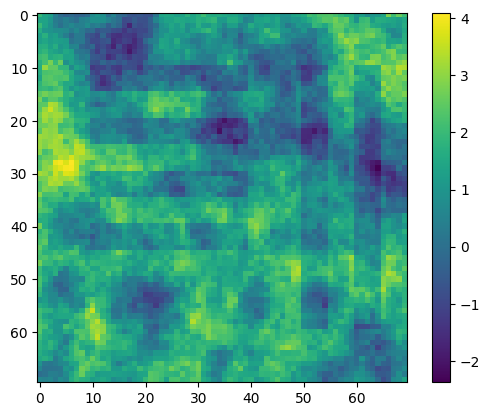

In [7]:
plt.imshow(x_ori)
plt.colorbar()
plt.show()

Add noise over the observations

In [8]:
key, subkey = jax.random.split(key)
true_sigma_noise = 0.01
y = x_ori + jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
#y = jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
N = H * W

In [9]:
#y = jnp.pad(y, 10)

In [10]:
mask = jnp.zeros_like(y)

# As advised by the article to avoid border effects
# mask = mask.at[:10, :].set(1)
# mask = mask.at[-10:, :].set(1)
# mask = mask.at[:, -10:].set(1)
# mask = mask.at[:, :10].set(1)
# H += 20
# W += 20
# N = H * W

mask = mask.at[20:60, 30:40].set(1)

y = jnp.where(mask == 0, y, 0)

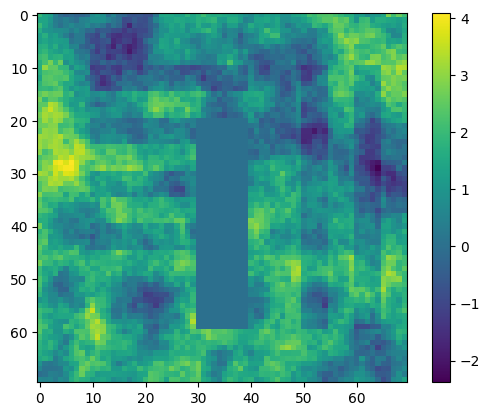

In [11]:
plt.imshow(y)
plt.colorbar()
plt.show()

## Define the DGMRF
In the supplementary material of Siden 2020 they claim that the biases are fixed to 0.

In [12]:
from dgmrf.models import DGMRF, MeanField, FactorizedS
from dgmrf.utils import get_adjacency_matrix_lattice

In [13]:
L = 6
Nq = 5

In [14]:
y = y.flatten()
mask = mask.flatten()

In [15]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(subkey, L, height_width=(H, W), with_bias=True)

Instanciate the variational distribution we can choose between **Mean-Field** variational distribution and the **factorized distribution** proposed by Oskarsson. While the latter gives slightly better results it is much slower.

In [16]:
key, subkey1, subkey2 = jax.random.split(key, 3)

q_phi = MeanField(N=H * W, key=subkey)
#q_phi = FactorizedS(N=H * W, dgmrf_args=(subkey1, 1), dgmrf_kwargs={"height_width":(H, W), "with_bias":True}, key=subkey2)

Define the Model equinox module `(DGMRF, VariationalDistribution, noise_parameter_array)`. This is just a container-like structure

In [17]:
from dgmrf.train import Model
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))

## Variational inference to compute model parameters

The initial values of the mean and std for the variational distribution are given lines 572 and 573 of the orignal code.

In [18]:
n_iter = 5000
lr_conv = 1e-3

lr = lr_conv
tx = optax.multi_transform(
    {'dgmrf': optax.rprop(lr), 'log_sigma': optax.rprop(0), 'q_phi': optax.rprop(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [19]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

print_every = 1000
key, subkey = jax.random.split(key, 2)
model, loss_val, opt_state = train_loop(dgmrf_elbo, model, y, n_iter, tx, opt_state, subkey, print_every, N, Nq, mask)

Iteration 0, loss_value = -21743.24609375
Iteration 1000, loss_value = 2.2744271755218506
Iteration 2000, loss_value = 2.2816696166992188
Iteration 3000, loss_value = 2.2810068130493164
Iteration 4000, loss_value = 2.2846693992614746
End of training (iteration 5000), loss_value = 2.2859890460968018


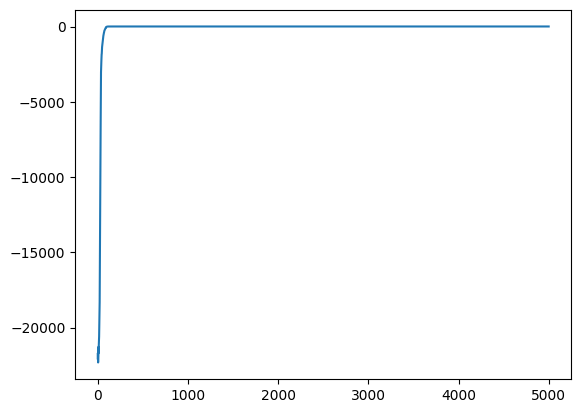

In [20]:
plt.plot(loss_val)
plt.show()

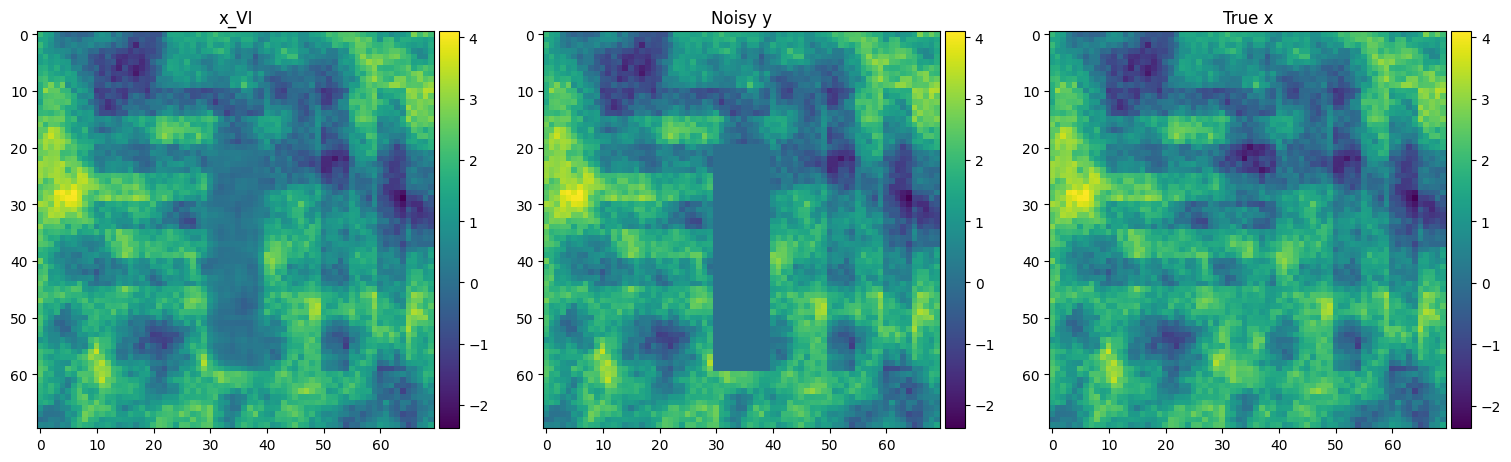

In [21]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(model.posterior.params["nu"].reshape(H, W))
axes[0].set_title("x_VI")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# im = axes[3].imshow(jnp.abs(params_final["nu_phi"].reshape(H, W) - x_ori))
# divider = make_axes_locatable(axes[3])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')
# axes[3].set_title("|x_VI - x|")

plt.show()

## Analyze the filters

Params for layer l=0 (Array(1.3626144, dtype=float32), Array(-0.28833643, dtype=float32), Array(-0.38954708, dtype=float32), Array(-0.3085021, dtype=float32), Array(-0.31862992, dtype=float32), Array(-0.23965962, dtype=float32), Array(0.70252734, dtype=float32))
Params for layer l=1 (Array(0.99118185, dtype=float32), Array(0.14969297, dtype=float32), Array(-0.12556542, dtype=float32), Array(0.14801593, dtype=float32), Array(-0.12820418, dtype=float32), Array(-0.10850503, dtype=float32), Array(0.80922496, dtype=float32))
Params for layer l=2 (Array(1.2367198, dtype=float32), Array(-0.19066764, dtype=float32), Array(0.2764717, dtype=float32), Array(-0.19916849, dtype=float32), Array(0.27022266, dtype=float32), Array(-0.01038306, dtype=float32), Array(0.7155121, dtype=float32))
Params for layer l=3 (Array(1.2895212, dtype=float32), Array(0.19736835, dtype=float32), Array(0.2971181, dtype=float32), Array(0.19422303, dtype=float32), Array(0.2968072, dtype=float32), Array(-0.5776488, dtype=f

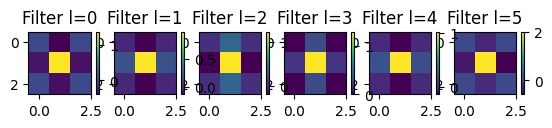

In [22]:
from dgmrf.layers import ConvLayer
fig.set_size_inches(30.5, 15.5)

fig, axes = plt.subplots(1, L + 1 if L == 1 else L)
for l in range(L):
    f1_ = ConvLayer.params_transform(model.dgmrf.layers[l].params)
    print(f"Params for layer {l=}", ConvLayer.params_transform(model.dgmrf.layers[l].params))
    f1 = jnp.array([[0, f1_[2], 0], [f1_[1], f1_[0], f1_[3]], [0, f1_[4], 0]])
    im = axes[l].imshow(f1)
    axes[l].set_title(f"Filter {l=}")
    divider = make_axes_locatable(axes[l])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

## Posterior mean computation with conjugate gradient

The next cell should output something more or less like the realization of the standard normal

[]

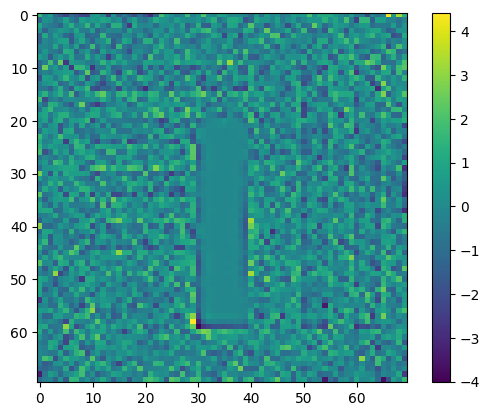

In [23]:
z = model.dgmrf(y)
plt.imshow(z.reshape((H, W)))
plt.colorbar()
plt.plot()

**Note**, on this example, we can still afford the computation of exactly inverting $\tilde{Q}$ to compute exactly the posterior mean without the conjugate gradient:

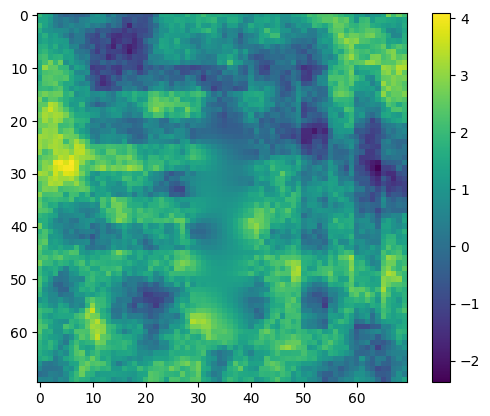

In [24]:
mu_post_exact = model.dgmrf.get_post_mu(
    y,
    model.noise_parameter,
    mask=mask,
    method="exact"
)
plt.imshow(mu_post_exact.reshape((H, W)))
plt.colorbar()
plt.show()

But we can also compute the posterior mean with approximate inversion of $\tilde{Q}$ using conjugate gradient.

In [28]:
mu_post_cg = model.dgmrf.get_post_mu(
    y,
    model.noise_parameter,
    mask=mask,
    method="cg"
)

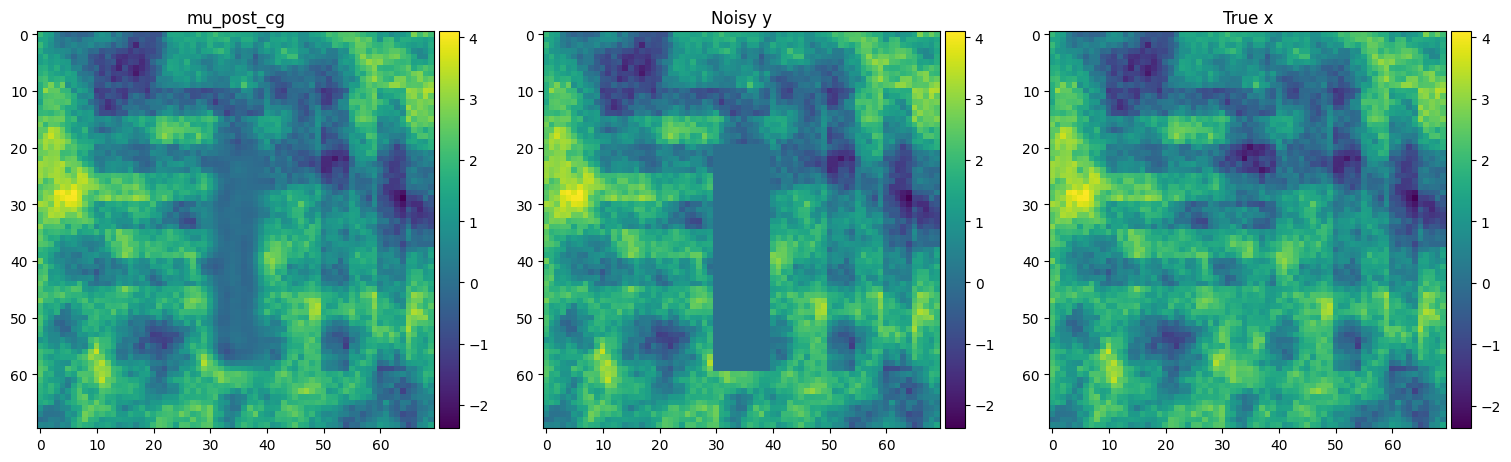

In [29]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(mu_post_cg.reshape(H, W))
axes[0].set_title("mu_post_cg")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Posterior samples to compute the posterior marginal variances

In [32]:
nb_samples = 50

key, subkey = jax.random.split(key, 2)
x_post_samples = model.dgmrf.posterior_samples(nb_samples, y, model.noise_parameter, subkey, mask=mask)

/tmp/ipykernel_12653/3468996589.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1850x1050 with 6 Axes> than <Figure size 1850x1050 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='vertical')
/tmp/ipykernel_12653/3468996589.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1850x1050 with 6 Axes> than <Figure size 1850x1050 with 5 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='vertical')
/tmp/ipykernel_12653/3468996589.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1850x1050 with 6 Axes> than <Figure size 1850x1050 with 6 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='vertical')


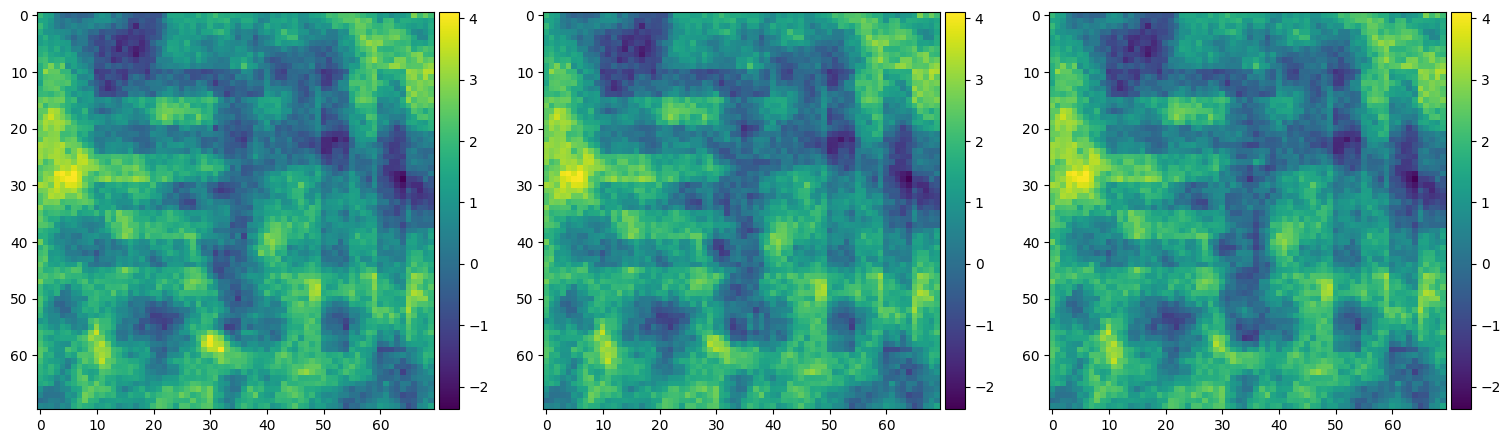

In [33]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

for i, ax in enumerate(axes):
    ax.imshow(x_post_samples[i].reshape(H, W))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

### Simple MC estimator

The masked areas are excluded from the computation of the variances

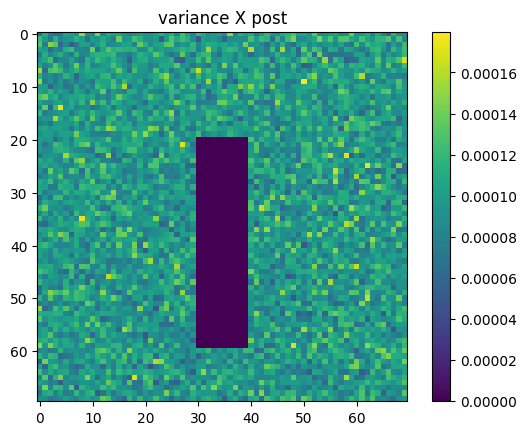

In [34]:
var_x_post_samples = jnp.var(jnp.stack([jnp.where(mask==0,x_post,0) for x_post in x_post_samples], axis=0), axis=0)
plt.imshow(var_x_post_samples.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()

### Simple Rao-Blackwellized Monte Carlo

In [35]:
var_x_post_samples_RBMC = model.dgmrf.rbmc_variance(x_post_samples, model.noise_parameter, mask=mask)

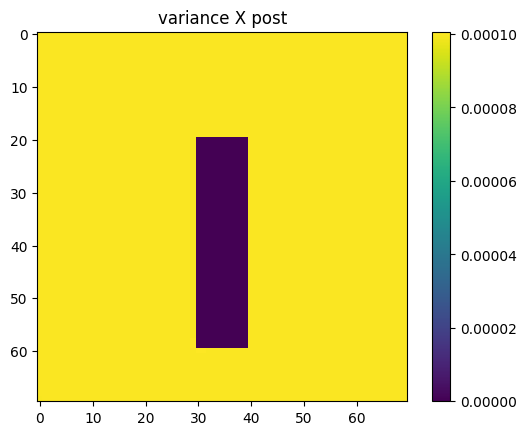

In [36]:
plt.imshow(var_x_post_samples_RBMC.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()